In [ ]:
%matplotlib widget
from IPython.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))

# Structured Variables
This are the main headline and some collected material for a tutorial about structured variables in dadk / BinPol. 

## VarShapeSet and BitArrayShape

A general quadratic unconstrained binary optimization problem takes the form
$$
\min_X \sum_{i=0}^{N-1} h_i x_i + \sum_{i=0}^{N-2} \sum_{j=i+1}^{N-1} w_{ij} x_i x_j,
$$
with $X = (x_0,\ldots,x_{N-1}) \in \{0,1\}^N$ and problem parameters $h_i,w_{ij}\in \mathbb{R}$ for $i,j\in \{0,\ldots, N-1\}$.
In most real world problems, each entry in the bit vector to optimize has a broader meaning like point in time or space. 
Even more, in many optimization problems, a single index is not enough, but a double or triple index is needed.
Imagine for example the Traveling Salesman Problem (TSP). Given $N$ cities with intermediate distances $dist_{c_1,c_2}>0$ for different cities $c_1,c_2$, one seeks the shortest round trip such that each city is visited exactly once.
Here, each bit in the problem denotes a city and the point in time when the city is visited. Instead of a single index as above, this gives rise to a bit vector 
$$
X = (x_{t,c})_{t \in \{0,\ldots,T-1\}, c \in cities},
$$
where $\{0,\ldots,T-1\}$ is the set of times, i.e. the number of cities, and $cities$ is the set of cities.
We would have two constraints enforcing that exactly one city is visited at each point in time and that each city is visited exactly once.
A third term expresses the actual optimization problem: 
$$
\min_X A \sum_{t=0}^{T-1} \left(1 - \sum_{c \in cities} x_{t,c}\right)^2  + B \sum_{c \in cities} \left(1 - \sum_{t=0}^{T-1} x_{t,c}\right)^2 + C \sum_{t=0}^{T-1} \sum_{c_1,c_2 \in cities: c_1\neq c_2} dist_{c_1,c_2} x_{t,c_1} x_{t+1,c_2}, \quad A,B,C >0.
$$
Such a problem can be implemented with a helper function that converts the two dimensional index $t,c$ to a one dimensional and vice versa.
To make implementations more pleasant and less error-prone, the concept of `VarShapeSet` and `BitShapeArray` is a good alternative.
It allows to define the shape and name of bit arrays in so called `BitShapeArray` objects, and store the collection of problem variables in a `VarShapeSet` object. QUBO formulation can then be implemented based on these indices.

But step by step.
Your first task is the following.
Choose five cities and store them as strings in a list `cities`. Also define a dictionary `distances` with distances between the cities. The distances do not have to be realistic. 

In [1]:
from dadk.QUBOSolverCPU import *
from dadk.Solution_SolutionList import *
from dadk.BinPol import *

random.seed(42)
# Initialize your favourite cities as strings in a list Cities and the pairwise distances as a dictionary distances.
# Define a BitShapeArray with appropriate name and shape for the bit variable with double index for time and city. 
#- Start coding here -######################################################################################################################
cities = ["Munich", "Hamburg", "Stuttgart", "Berlin", "Frankfurt"]

distances = {}
for cindex1 in range(len(cities)-1):
    c1 = cities[cindex1]
    for cindex2 in range(cindex1+1,len(cities)):
        c2 = cities[cindex2]
        distances[c1,c2] = random.randint(1,6)
        distances[c2,c1] = distances[c1,c2]
        
print(distances)
######################################################################################################################- Stop coding here -#

{('Munich', 'Hamburg'): 6, ('Hamburg', 'Munich'): 6, ('Munich', 'Stuttgart'): 1, ('Stuttgart', 'Munich'): 1, ('Munich', 'Berlin'): 1, ('Berlin', 'Munich'): 1, ('Munich', 'Frankfurt'): 6, ('Frankfurt', 'Munich'): 6, ('Hamburg', 'Stuttgart'): 3, ('Stuttgart', 'Hamburg'): 3, ('Hamburg', 'Berlin'): 2, ('Berlin', 'Hamburg'): 2, ('Hamburg', 'Frankfurt'): 2, ('Frankfurt', 'Hamburg'): 2, ('Stuttgart', 'Berlin'): 2, ('Berlin', 'Stuttgart'): 2, ('Stuttgart', 'Frankfurt'): 6, ('Frankfurt', 'Stuttgart'): 6, ('Berlin', 'Frankfurt'): 1, ('Frankfurt', 'Berlin'): 1}


To give you an idea about the laboriousness to implement QUBOs with self-written index functions, below you find the code for TSP in this form with weighting constants $A=B=100$ and $C=1$. The function `my_index_function` takes a time index, a city index, and the number of cities in the problem, and computes a flat index from it, which has to be addressed when adding terms to a QUBO. After minimization of the QUBO, the solution will be a flat bit array of zeros and ones. In order to obtain the actual solution of the TSP, a function `my_index_retrieval_function` is needed to retrieve the time and city indices from a flat index in the solution bit array. The function therefore takes a flat index and the number of cities in the problem as arguments.

Let's have a look at an example in order to understand the index conversion better.
<img src="bit_matrix.png" alt="Drawing" style="width: 700px;"/>
The image above shows a matrix with times as rows and cities as columns. Each two dimensional index has to be converted to a flat index. In the picture, you can see the resulting flat bit indices which have to be addressed in building the QUBO and later in the solution's configuration.  

In [2]:
def my_index_function(time_index,city_index,number_cities):
    return number_cities*time_index + city_index

def my_index_retrieval_function(flat_index,number_cities):
    time_index = flat_index // number_cities
    city_index = flat_index % number_cities
    return (time_index,city_index)

my_laborious_qubo = BinPol()

for t in range(4):
    for c_index1, c1 in enumerate(cities):
        for c_index2, c2 in enumerate(cities):
            if c1 != c2:
                my_laborious_qubo.add_term(distances[c1,c2],(my_index_function(t,c_index1,5), my_index_function(t+1,c_index2,5)))
                
for t in range(4):
    one_city_each_time = BinPol()
    one_city_each_time.add_term(-1)
    for c_index, c in enumerate(cities):
        one_city_each_time.add_term(1,(my_index_function(t,c_index,5),))
    one_city_each_time.power(2)
    one_city_each_time.multiply_scalar(100)
    my_laborious_qubo.add(one_city_each_time)


for c_index, c in enumerate(cities):
    one_time_each_city = BinPol()
    one_time_each_city.add_term(-1)
    for t in range(4):
        one_time_each_city.add_term(1,(my_index_function(t,c_index,5),))
    one_time_each_city.power(2)
    one_time_each_city.multiply_scalar(100)
    my_laborious_qubo.add(one_time_each_city)
    

Now imagine you would like to fix a certain city in your round trip. More precisely, let's say you want to visit a certain city in your round trip at some fixed point in time.
In the example above, you might want to visit Stuttgart exactly as the third city of your trip.
<img src="bit_matrix_constant_bits.png" alt="Drawing" style="width: 700px;"/>
As you can see, this fixes exactly the bit corresponding to time three and city Stuttgart to be True (or one), and the rest bits in the same row and column to be False (or zero). For the Digital Annealer, such gaps in a QUBO do not exist. Hence, the index function `my_index_function` above would have to push the bit indices together, such that no gaps exist.
You can see the result in the picture above. 
Conversely, the retrieval function `my_index_retrieval_function` would first  have to pull the flat index apart appropriately, and only then compute the corresponding time and city index.
Now imagine how much more complicated things get if you want to fix several not consecutive cities in your list to certain time points. This makes transformations of indices more and more complicated, especially if a variable in an optimization problem has a higher dimensional index, or if there is more than only one variable involved, and all the variables have different index dimensions. 

In order to get around complicated index transformations, we want to implement the TSP qubo with help of a `VarShapeSet` and a `BitArrayShape`.

Below, you find implemented a `numpy.ndarray` object `my_constant_bits` in the shape corresponding to your TSP.
Such an object can be used to define constant bits in a problem in an elegant and comfortable way. A minus one in the array means that the corresponding bit is not fixed but variable, and as such part of the annealing which does the optimization.
A zero in the constant bit array means that the corresponding bit is fixed to False (or zero), and a one means that it is fixed to True (or one).
Such bits will not be part of the annealing. 
All forth and back transformations of flat indices are done internally by the library.
As you will probably have noticed, all entries in the array below are set to minus one, which means that all bits in the TSP will be variable.

In order to make things even more comfortable, you find a function `my_call_back` already implemented below. It takes a `numpy.ndarray` data array of the shape of your two dimensional variable index and the list of cities as arguments. The data array is assumed to have ones at positions which correspond to times and cities of the optimal round trip, while all other entries are assumed to be zero. You will see later in this tutorial how such a data array is provided to the method after optimization.
Based on the information in the data array, the method computes the round trip as a list of consecutive cities from the list of cities, prints the solution and returns the round trip. 
The callback function, if provided to a `BitArrayShape` object upon initialization, will simplify interpretation of the solution after annealing a lot.

Your task in the following is to define a `BitArrayShape` object with `name` `"tsp_array"` and appropriate `shape`. Also provide the axis names `"time"` and `"city"` in the argument `axis_names` in form of a list of strings. Define the constant bits for the problem by the argument `constant_bits` as `my_constant_bits`, and set the callback function with help of the argument `call_back` to `my_call_back`.

Tip with regard to `shape`: Imagine you would like to define a `numpy.ndarray` for the bit array in the TSP. The shape of the `BitArrayShape` object is exactly that.

Next, define a `VarShapeSet` object with your `BitArrayShape` object as an argument of initialization.

Remark: Alternatively, a list of `BitArrayShape` objects can be given to `VarShapeSet` upon initialization. In this case, in order to de-reference the list, a * has to be typed in front of the list. To understand this concept, add your `BitArrayShape` object to a list and try to initialize your `VarShapeSet` object this way.

In [3]:
my_constant_bits = np.full((5,5), -1, np.int8)

def my_call_back(data,cities=cities):
    round_trip = [cities[city_index] for city_index in np.nonzero(data)[1]]
    print(f'Computed roundtrip: {round_trip}')
    return round_trip

#- Start coding here -######################################################################################################################
my_bit_shape_array = BitArrayShape(name='tsp_array', shape=(5,5), axis_names=['time','city'], constant_bits=my_constant_bits, call_back=my_call_back) 

my_varshapeset = VarShapeSet(my_bit_shape_array)

my_varshapeset = VarShapeSet(*[my_bit_shape_array])
######################################################################################################################- Stop coding here -#

Now that the shape of your bit array is stored in a `VarShapeSet`, the latter can be provided to a `BinPol` object upon initialization. 
After doing so, the QUBO's `add_term` method can be called with a coefficient and a tuple containing tuples of names and index specifications of `BitShapeArray`'s in your `VarShapeSet`. More precisely, the method is called by 

`add_term(<coef>, ((<bit_shape_array_name1>, <index_dim_0>, ..., <index_dim_N-1> ), (<bit_shape_array_name2>, <index_dim_0>, ..., <index_dim_N-1> ), ...))`, 

where `<coef>`is the coefficient to be multiplied to the new term. Each entry in the tuple that follows has the form 

`(<bit_shape_array_name>, <index_dimension_0>, ..., <index_dimension_N-1>)`,

and specifies a QUBO variable by a tuple with the name of the respective `BitShapeArray` object, and the indices of the variable to address.
An example would be and entry for the `BitShapeArray` `tsp_array` from above, which represents a variable $x_{t,c}$ in the QUBO for the TSP.

Your task in the following is to complete the code below. 
Fill in the missing entries in the `add_term` methods such that your QUBO represents the formula

$$
\min_X A \sum_{t=0}^{T-1} \left(1 - \sum_{c \in cities} x_{t,c}\right)^2  + B \sum_{c \in cities} \left(1 - \sum_{t=0}^{T-1} x_{t,c}\right)^2 + C \sum_{t=0}^{T-1} \sum_{c_1,c_2 \in cities: c_1\neq c_2} dist_{c_1,c_2} x_{t,c_1} x_{t+1,c_2}, \quad A=B=100, C = 1.
$$

Add the missing `VarShapeSet` from above as argument in the definition of each QUBO below. 

In [4]:
#- Start coding here -######################################################################################################################
H=BinPol(my_varshapeset)
for t in range(4):
    for c_index1, c1 in enumerate(cities):
        for c_index2, c2 in enumerate(cities):
            if c1 != c2:
                H.add_term(1*distances[c1,c2],(("tsp_array",t,c_index1), ("tsp_array",t+1,c_index2)))

H1=BinPol(my_varshapeset)
for t in range(5):
    one_city_each_time = BinPol(my_varshapeset)
    one_city_each_time.add_term(-1)
    for c_index, c in enumerate(cities):
        one_city_each_time.add_term(1,(("tsp_array",t,c_index),))
    one_city_each_time.power(2)
    one_city_each_time.multiply_scalar(100)
    H1.add(one_city_each_time)

H2=BinPol(my_varshapeset)
for c_index, c in enumerate(cities):
    one_time_each_city = BinPol(my_varshapeset)
    one_time_each_city.add_term(-1)
    for t in range(5):
        one_time_each_city.add_term(1,(("tsp_array",t,c_index),))
    one_time_each_city.power(2)
    one_time_each_city.multiply_scalar(100)
    H2.add(one_time_each_city)
    
my_qubo = H + H1 + H2
######################################################################################################################- Stop coding here -#

Now that the QUBO is defined, we want to find its energy minimizing configuration.
The code for the solver and computation of the solution is already implemented below. You just have to execute it.

In [5]:
solver = QUBOSolverCPU(
    number_iterations=1000,
    temperature_start=1000,
    temperature_end=10)

solution_list = solver.minimize(my_qubo)

solution = solution_list.min_solution

print(solution.configuration)

[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]


The solution is computed, but its configuration attribute is a list of zeros and ones. So how to obtain the actual round trip from it?
Below you find the code for the laborious way with help of the `my_index_retrieval_function` which has been implemented above, and which converts a flat index position in the configuration to a tuple of time and city index. The optimal round trip can now be obtained from the configuration by converting all flat index positions, where the configuration has a one as entry, to tuples of time and city index, and sorting the resulting list by time index. Then the city indices in the tuple list are in the order of the round trip, and the corresponding cities can be read from the list `cities`.

Remember how much more complicated things would get with some constant bits as in the example above.

In [6]:
configuration = solution.configuration
round_trip_index_tuples = []
for flat_index in range(len(configuration)):
    if configuration[flat_index]:
        round_trip_index_tuples.append(my_index_retrieval_function(flat_index,5))

round_trip = [cities[t_index_c_index[1]] for t_index_c_index in sorted(round_trip_index_tuples, key = lambda t_index_c_index: t_index_c_index[0])]
print(f'Computed roundtrip: {round_trip}')

Computed roundtrip: ['Frankfurt', 'Berlin', 'Munich', 'Stuttgart', 'Hamburg']


## Bit arrays
Luckily, we do not have to bother with such complicated implementations anymore. Our call back function has already been provided to the `BitShapeArray` and the latter is part of our `VarShapeSet`. 

Therefore we can obtain a so called `BitArray` from the solution object, by calling its `extract_bit_array` method with the name of our `BitShapeArray` object, i.e. `"tsp_array"` as argument. 
This object then already obtains a two dimensional `numpy.ndarray` matrix of zeros and ones as attribute `data`, where dimension zero corresponds to time indices, and dimension one to city indices. The ones are exactly at those positions of the array, which are part of the optimal solution, and as such of the optimal round trip. 
The data array can also be visualized with help of the bit arrays `draw` method. Moreover, the bit array inherited the axis names for the data array from the bit shape array, so that they are drawn as well. Zeros in the data array are plotted in blue, while ones are plotted in red. Fixed bits are plotted in a pale style, while variable bits which have been part of the annealing are plotted in a solid way. You can change the axis order by providing the `draw` method an argument `order`, which is a list of axis indices. The default order in our case is `[0,1]`, i.e. time has dimension zero, while city has dimension one.

As your last task in this section, extract a `BitArray` object from the `solution` by calling its `extract_bit_array` method with the name of your `BitShapeArray` as argument. This method extracts the part of the solution's configuration list which belongs to your `BitShapeArray`. It converts it to a data array of the shape of the `BitShapeArray` from your `VarShapeSet`. Finally, it returns a `BitArray` object with the same name as the `BitShapeArray` object and the data array as attribute `data`. 
Visualize the data array by calling the object's `draw` method, such that cities appear in the abscissa, while times appear in the ordinate.
The`BitArray` object also inherits the callback function from the `BitShapeArray` as implemented above. Therefore, the object's `evaluate` method - without any arguments - internally calls the callback function with the `data` attribute and the list `cities` as arguments, and thus prints and returns the computed round trip. 
Call the bit array's `evaluate` method to compute the optimal round trip of the TSP.

Value of constraint one city at each time: 0
Value of constraint one time for each city: 0


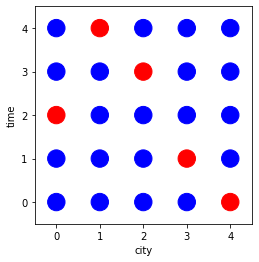

Computed roundtrip: ['Frankfurt', 'Berlin', 'Munich', 'Stuttgart', 'Hamburg']


['Frankfurt', 'Berlin', 'Munich', 'Stuttgart', 'Hamburg']

In [7]:
print(f'Value of constraint one city at each time: {H1.compute(solution.configuration)}')
print(f'Value of constraint one time for each city: {H2.compute(solution.configuration)}')

#- Start coding here -######################################################################################################################
my_bit_array = solution.extract_bit_array("tsp_array")
my_bit_array.draw(order=[1,0])
my_bit_array.evaluate()
######################################################################################################################- Stop coding here -#

# Bonus exercise: Now with constant bits
As a diligent task, you can implement the whole code from above with constant bits. For example, try to fix the third city in your list to the third time of the round trip. Remember that this fixes several other bits to zero because of the constraints to visit exactly one city at each time and to assign exactly one time to each city.

If you are even more eager, try to implement the same problem without `VarShapeSet`, `BitArrayShape` and `BitArray` by writing your own index conversion functions.

The numpy package is already imported as `np`.

Comment: Imagine fixing several not consecutive cities in your list to certain times of the round trip and how this would complicate index conversion even more.

In [8]:
#- Start coding here -######################################################################################################################

######################################################################################################################- Stop coding here -#

# VarSlack

In quadratic constraint binary optimization problems, one frequently wants to express inequality conditions with respect to a constant, e.g.
$$
x_0 + x_1 \leq 2.
$$
Such statements cannot simply be formulated in a relaxed way and added to the optimization target as is done for equality constraints. Therefore, we need another way to convert a problem with inequality conditions into a polynomial that expresses a quadratic unconstrained binary optimization problem (QUBO).
To this aim, a helper variable called `slack variable` is introduced. This variable obtains auxiliary bits which express a bit variable that can take values within a certain range. One then converts the inequality constraint to an equality constraint with respect to the slack variable.
In the example above, the slack variable $S$ could be defined as $S = x_2 + x_3,$ and thus would be able to take values in $\{0,1,2\}$. The corresponding equality constraint would be
$$
x_0 + x_1 - S = 0.
$$
This constraint can then be added to the optimization target as
$$
C (x_0 + x_1 - S)^2,
$$
with $C>0$ large enough, and minimization of this additional term enforces the original inequality constraint 
$$
x_0 + x_1 \leq 2.
$$

The slack variable $S$ could be implemented with help of a `BitShapeArray` object.
However, since slack variables are used frequently, there already exits a class `VarSlack`.
As for `BitShapeArray` objects, a `VarSlack` is initialized with a `name`.
Moreover, the range to be represented by the variable is specified by keyword arguments `start`, `stop` and `step`, as for the built in `range` function.
Finally, the `slack_type` is specified. It denotes the way in which the desired range is represented. 
For example, `slack_type = SlackType.unary` gives rise to a unary slack variable $S = \sum_{i=0}^N x_i$, whereas `slack_type = SlackType.binary` stands for a binary variable of the form $S = \sum_{i=0}^N 2^i x_i$, with appropriate $N\geq0$. The binary representation needs less bits than the unary representation, which gets important for large problem instances when bits are rare or if the range to represent is large.

There also exist the slack types `SlackType.sequential`, `SlackType.littlegauss` and `SlackType.fibonacci` which you can experiment with below.
Your first task in this exercise is to define a `VarSlack` object representing the values $\{0,1,2,\ldots,63\}$.
Try different slack types and observe the effect on the `length` attribute of the object. This tells you how many bits will be needed for the variable.

Next, define a `VarShapeSet` containing your slack variable. Afterwards, initialize a `BinPol` object `qubo` based on your `VarShapeSet` and add the slack variable by calling the `add_slack_variable` method of the BinPol object with the name of the slack variable as parameter.
Print your BinPol object for different slack types and observe the different representations of the range $\{0,1,2,\ldots,63\}$.

In [9]:
from random import randint

# Initialize a VarSlack for a range {0,1,2,\ldots,63\}. Experiment with different slack_types and observe the effect on the length attribute 
#- Start coding here -######################################################################################################################
my_var_slack = VarSlack(name='slack_variable',start=0,step=1,stop=63,slack_type=SlackType.binary)
print(f"Length of the slack variable: {my_var_slack.length}")
######################################################################################################################- Stop coding here -#

#Define a VarShapeSet containing your VarSlack object, initialize a BinPol object p on the VarShapeSet and add the slack variable
#- Start coding here -######################################################################################################################
var_shape_set = VarShapeSet(my_var_slack) 
qubo = BinPol(var_shape_set).add_slack_variable('slack_variable')
print(f"Qubo representation of the slack variable: {qubo}")
######################################################################################################################- Stop coding here -#

Length of the slack variable: 6
Qubo representation of the slack variable: x_0 + 2.0 x_1 + 4.0 x_2 + 8.0 x_3 + 16.0 x_4 + 31.0 x_5


The code for an artificial `Solution` object `solution` for your polynomial of the previous exercise is already implemented.
As your last task in this tutorial, extract a `BitArray` object from the solution by calling its `extract_bit_array` method with the name of your slack variable as argument. This method extracts the part of the solution's configuration list which belongs to your slack variable. It converts it to a data array of the shape of the slack variable or of the `BitShapeArray` in case you provide the name of a `BitShapeArray` from your `VarShapeSet`. Finally, it returns a `BitArray` object with the same name as the `VarSlack` or `BitShapeArray` object and the data array. In case of a `VarSlack`, the callback function is already implemented such that the object's `evaluate` method returns the value of the slack variable from the data array. In the case of a `BitShapeArray`, in order to apply this functionality, a callback function has to be implemented upon initialization as you saw in the exercises for the TSP above in the beginning of this notebook.
Call the bit array's `evaluate` method to compute the value of the slack variable, and visualize its data array with help of the `draw` method.

Value of slack variable: 2.0


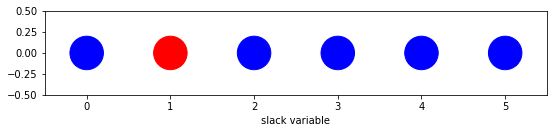

In [10]:
my_bit_config = [randint(0,1) for b in range(len(qubo.p))]
solution = Solution(configuration=my_bit_config,var_shape_set=var_shape_set)

#Extract a BitArray object from the Solution object above using its extract_bit_array method. Evaluate the BitArray object and visualize 
#its data array
#- Start coding here -######################################################################################################################
my_bit_array = solution.extract_bit_array('slack_variable')
print(f"Value of slack variable: {my_bit_array.evaluate()}")
my_bit_array.draw(axis_names=['slack variable'])
######################################################################################################################- Stop coding here -#

Once you finished all exercises, you can compare to the solutions by clicking the following link:

[Structured Variables Solution](./I_03_Structured_Variables_Solution.ipynb)

[](#section_id)